<a href="https://colab.research.google.com/github/Osalhi-7X/newwebsite/blob/main/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mc2technologies","key":"bb47244590e84e79768a4356b762eccd"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets list

ref                                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset                    Customer Shopping (Latest Trends) Dataset            76KB  2024-11-23 15:26:12          15527        305  1.0              
hopesb/student-depression-dataset                                      Student Depression Dataset.                         454KB  2024-11-22 17:56:03          12333        158  1.0              
kanchana1990/uber-customer-reviews-dataset-2024                        Uber Customer Reviews Dataset (2024)                459KB  2024-12-19 19:05:47            638         30  1.0              
mujtabamatin/air-quality-

In [6]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 57.2MB/s]


In [7]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [34]:
!pip install tensorflow_decision_forests
!pip install wurlitzer  # Optional, for better logging

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
   

In [35]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("TensorFlow Decision Forests version:", tfdf.__version__)

TensorFlow version: 2.18.0
TensorFlow Decision Forests version: 1.11.0


**Loading the Data**

In [36]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Remove ID column from training data
train_data = train_data.drop(columns=['Id'])

# Display basic info
print(train_data.info())
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

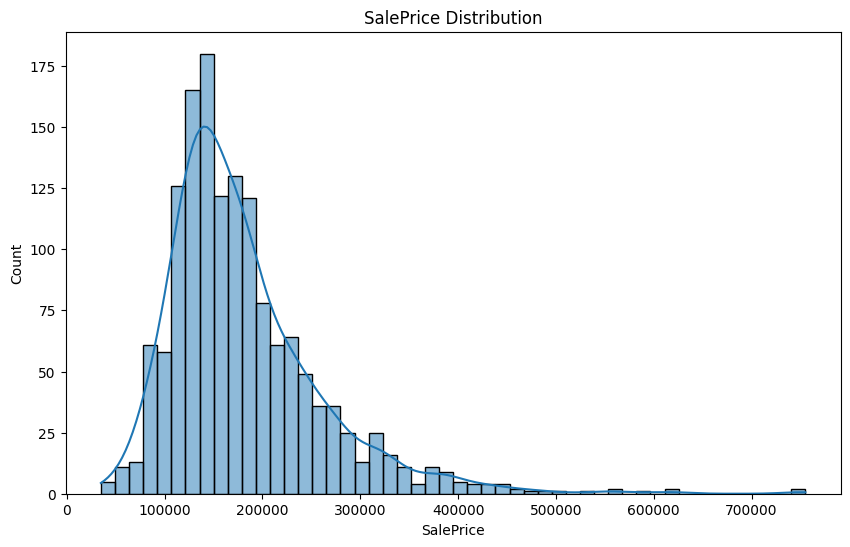

In [37]:
# SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=50)
plt.title("SalePrice Distribution")
plt.show()


In [38]:
# Check missing values
missing = train_data.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [39]:
# Fill missing numerical values with median
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].median())

# Fill missing categorical values with "None"
categorical_cols = train_data.select_dtypes(include=['object']).columns
train_data[categorical_cols] = train_data[categorical_cols].fillna("None")

In [40]:
# Split into train and validation sets
def split_dataset(dataframe, test_ratio=0.2):
    test_indices = np.random.rand(len(dataframe)) < test_ratio
    return dataframe[~test_indices], dataframe[test_indices]

train_ds, valid_ds = split_dataset(train_data)

# Prepare TensorFlow datasets
train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
valid_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds, label="SalePrice", task=tfdf.keras.Task.REGRESSION)


In [41]:
# Define the model
model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

# Train the model
model.fit(train_tfds)


Use /tmp/tmpki0mtsl6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:10.362398. Found 1139 examples.
Training model...
Model trained in 0:00:02.978342
Compiling model...
Model compiled.


1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00
Validation Metrics: {'loss': 0.0}


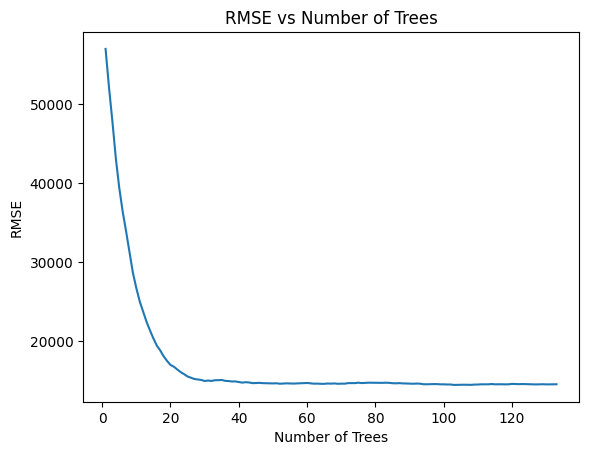

In [42]:
evaluation = model.evaluate(valid_tfds, return_dict=True)
print("Validation Metrics:", evaluation)

# Plot RMSE against the number of trees
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Trees")
plt.show()

In [43]:
# Display feature importance
inspector = model.make_inspector()
print("Feature Importances:")
for importance in inspector.variable_importances()["NUM_AS_ROOT"]:
    print(f"{importance[0].name}: {importance[1]}")

Feature Importances:
OverallQual: 16.0
LotConfig: 11.0
BsmtExposure: 8.0
GrLivArea: 8.0
3SsnPorch: 6.0
YearRemodAdd: 6.0
BedroomAbvGr: 5.0
ExterQual: 5.0
GarageYrBlt: 5.0
Exterior1st: 4.0
LotArea: 4.0
Condition2: 3.0
FullBath: 3.0
MasVnrArea: 3.0
1stFlrSF: 2.0
GarageArea: 2.0
MSZoning: 2.0
OpenPorchSF: 2.0
TotalBsmtSF: 2.0
2ndFlrSF: 1.0
Foundation: 1.0
Functional: 1.0
KitchenQual: 1.0
Neighborhood: 1.0
ScreenPorch: 1.0


In [44]:
# Impute missing values in test data
test_data = test_data.fillna({
    col: test_data[col].median() if col in numerical_cols else "None"
    for col in test_data.columns
})

# Remove ID column
ids = test_data.pop("Id")

# Convert test data to TensorFlow dataset
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=tfdf.keras.Task.REGRESSION)

In [45]:
# Make predictions on test data
predictions = model.predict(test_tfds)

# Prepare submission file
submission = pd.DataFrame({"Id": ids, "SalePrice": predictions.squeeze()})
submission.to_csv("submission.csv", index=False)
print(submission.head())

2/2 [==============================] - 1s 66ms/step
     Id      SalePrice
0  1461  126374.515625
1  1462  149138.000000
2  1463  194517.296875
3  1464  191407.484375
4  1465  194303.203125


In [48]:
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=500,  # Number of trees
    max_depth=6     # Maximum tree depth
)

# Train the model
model.fit(train_tfds)


Use /tmp/tmpvw7av_sm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.978726. Found 1139 examples.
Training model...
Model trained in 0:00:04.100183
Compiling model...
Model compiled.


In [49]:
# Evaluate the model on the validation dataset
evaluation = model.evaluate(valid_tfds, return_dict=True)

# Print the evaluation results
for metric, value in evaluation.items():
    print(f"{metric}: {value:.4f}")


1/1 [==============================] - 1s 505ms/step - loss: 0.0000e+00
loss: 0.0000


OOB Evaluation: Evaluation(num_examples=None, accuracy=None, loss=14419.513671875, rmse=14419.513671875, ndcg=None, aucs=None, auuc=None, qini=None)


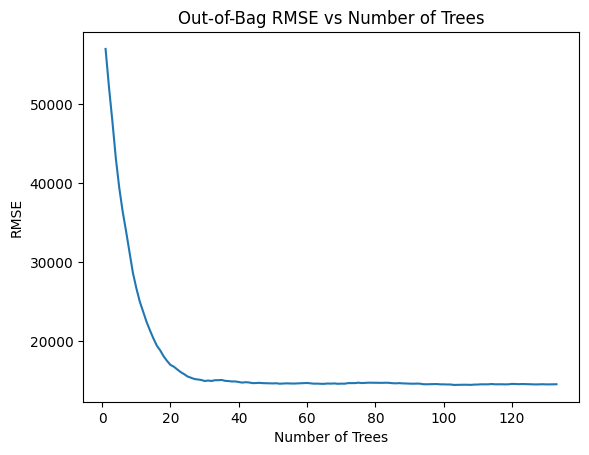

In [50]:
# Access the model's inspector
inspector = model.make_inspector()

# Print out-of-bag evaluation statistics
print("OOB Evaluation:", inspector.evaluation())

# Plot RMSE against the number of trees
logs = inspector.training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Out-of-Bag RMSE vs Number of Trees")
plt.show()


1/1 [==============================] - 2s 2s/step
   Actual      Predicted
0  143000  148339.343750
1  200000  240575.843750
2  139000  133811.343750
3  306000  328245.187500
4  145000  143104.671875


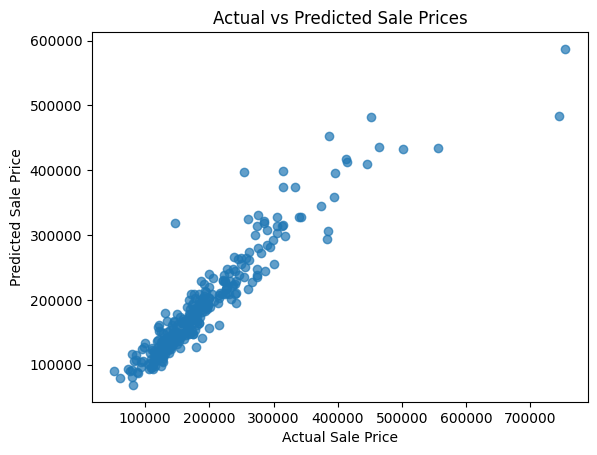

In [51]:
# Predict on validation data
valid_predictions = model.predict(valid_tfds)

# Create a comparison DataFrame
valid_comparison = pd.DataFrame({
    "Actual": valid_ds["SalePrice"].values,  # Actual sale prices
    "Predicted": valid_predictions.squeeze()  # Predicted sale prices
})

# Print the first few rows
print(valid_comparison.head())

# Plot Actual vs Predicted
plt.scatter(valid_comparison["Actual"], valid_comparison["Predicted"], alpha=0.7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

In [52]:
# Predict on test dataset
test_predictions = model.predict(test_tfds)

# Prepare the submission file
submission = pd.DataFrame({
    "Id": ids,  # The 'Id' column from the test dataset
    "SalePrice": test_predictions.squeeze()
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print(submission.head())

2/2 [==============================] - 2s 49ms/step
     Id      SalePrice
0  1461  126374.515625
1  1462  149138.000000
2  1463  194517.296875
3  1464  191407.484375
4  1465  194303.203125


In [57]:
# Initialize the model
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=1000,      # Set a high limit for trees
    max_depth=6,         # Moderate tree depth
    shrinkage=0.05       # Low learning rate for better generalization
)

# Train the model
model.fit(train_tfds)

# Evaluate the model on validation data
evaluation = model.evaluate(valid_tfds, return_dict=True)
# Inspect evaluation metrics
print("Evaluation keys:", evaluation.keys())
# Extract 'loss' (MSE) and calculate RMSE
rmse = np.sqrt(evaluation['loss'])
print(f"Validation RMSE: {rmse:.4f}")
# Extract RMSE directly if available
if 'rmse' in evaluation:
    print(f"Validation RMSE: {evaluation['rmse']:.4f}")


Use /tmp/tmpxp_pfh0q as temporary training directory
Reading training dataset...


Training dataset read in 0:00:02.210446. Found 1139 examples.
Training model...
Model trained in 0:00:03.577725
Compiling model...
Model compiled.


1/1 [==============================] - 1s 624ms/step - loss: 0.0000e+00
Evaluation keys: dict_keys(['loss'])
Validation RMSE: 0.0000


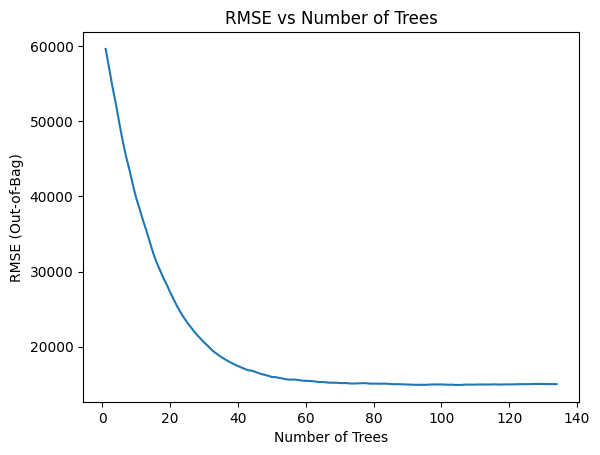

In [58]:
# Access the training logs
inspector = model.make_inspector()
logs = inspector.training_logs()

# Plot RMSE against the number of trees
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of Trees")
plt.ylabel("RMSE (Out-of-Bag)")
plt.title("RMSE vs Number of Trees")
plt.show()


In [59]:
# Check validation dataset
print(valid_ds.head())

# Check for missing values
print(valid_ds.isnull().sum())


    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
5           50       RL         85.0    14115   Pave  None      IR1   
7           60       RL         69.0    10382   Pave  None      IR1   
19          20       RL         70.0     7560   Pave  None      Reg   
27          20       RL         98.0    11478   Pave  None      Reg   
36          20       RL        112.0    10859   Pave  None      Reg   

   LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
5          Lvl    AllPub    Inside  ...        0   None  MnPrv        Shed   
7          Lvl    AllPub    Corner  ...        0   None   None        Shed   
19         Lvl    AllPub    Inside  ...        0   None  MnPrv        None   
27         Lvl    AllPub    Inside  ...        0   None   None        None   
36         Lvl    AllPub    Corner  ...        0   None   None        None   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
5      700     10    2009        WD     

1/1 [==============================] - 0s 473ms/step
   Actual      Predicted
0  143000  149207.609375
1  200000  231561.812500
2  139000  134182.046875
3  306000  322941.875000
4  145000  144528.656250


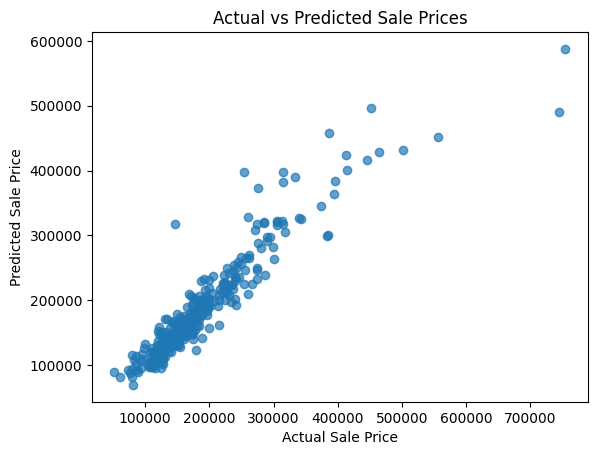

In [61]:
# Predict on validation dataset
predictions = model.predict(valid_tfds)

# Extract actual values
actual_values = valid_ds["SalePrice"].values

# Compare predictions with actual values
comparison = pd.DataFrame({
    "Actual": actual_values,
    "Predicted": predictions.squeeze()
})

print(comparison.head())

# Plot actual vs predicted values
plt.scatter(comparison["Actual"], comparison["Predicted"], alpha=0.7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

In [66]:
# Convert test data to TensorFlow dataset
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=tfdf.keras.Task.REGRESSION)

# Predict on the test dataset
test_predictions = model.predict(test_tfds)

# Create the submission DataFrame
submission = pd.DataFrame({
    "Id": ids,
    "SalePrice": test_predictions.squeeze()
})

# Save to CSV for Kaggle submission
submission.to_csv("submission.csv", index=False)

# Check the first few rows of the submission file
print(submission.head())

2/2 [==============================] - 1s 24ms/step
     Id      SalePrice
0  1461  125084.140625
1  1462  151343.437500
2  1463  187581.046875
3  1464  188410.171875
4  1465  189239.281250
